In [167]:
# Basic packages
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns  # for prettier plots
import matplotlib.style as style
style.use('ggplot')

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import scipy.special as sc
from scipy.stats import invgamma 

# settings
import warnings
warnings.filterwarnings("ignore")

In [14]:
def tsplot(y, lags=None, figsize=(14, 8), style='ggplot',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        # Defining the subplot axes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        # Auto correlation plot(MA)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        # Parcial ACF(AR)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        plt.plot()

# 1)

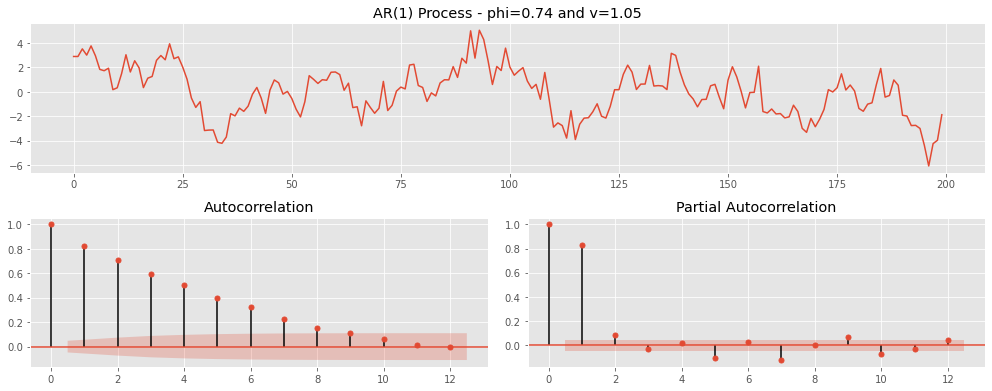

In [65]:
# Simulate an AR(1) process
#np.random.seed(1)
n_samples = int(200)
phi = np.random.uniform(low=0.7, high=0.95, size=1)[0]
v = np.random.uniform(low=0.75, high=2, size=1)[0]
y = e = np.random.normal(size=n_samples, loc=0, scale=v)

for t in range(n_samples):
    y[t] = phi*y[t-1] + e[t]
    

_ = tsplot(y, lags=12,title=f"AR(1) Process - phi={round(a,2)} and v={round(v,2)}")

* Knowing that our process has errors following a normal distribution, the estimation via maximum likelihood is simply the OLS(Métodos minimos quadrados) approach to find /phi and v, so using this result we have that:


$$\widehat{\phi} = \frac{\frac{1}{T}\sum_{t=1}^{T} y_{t-1}\: y_{t}}{\frac{1}{T}\sum_{t=1}^{T} y_{t-1}^{2}}$$

$$\widehat{v} = \frac{1}{T}\sum_{t=1}^{T} \widehat{\varepsilon_{t}}^{2}$$

$$\widehat{\varepsilon_{t}} = y_{t}-\widehat{\phi}y_{t-1} $$

$$ T = n - p $$

In [66]:
def maximum_likelihood_ar_1(y, n_samples, p=1):
    T = n_samples - p
    
    print(T)
    # Finding phi estimate via OLS(maximum likelihood when errors = normal distribution)
    u = l = 0
    for t in range(1, T):
        u += y[t-1]*y[t]
        l += y[t-1]**2
        
    phi_hat = u/l
    
    # Finding v (error variance)
    v_hat = 0
    for t in range(1, T):
        v_hat += ((y[t] - phi_hat*y[t-1])**2)
    
    v_hat /= T
        
    return phi_hat, v_hat

In [211]:
real = phi, v

In [212]:
max_est = maximum_likelihood_ar_1(y, n_samples)

199


In [213]:
print(f'AR(1):\nReal/Actual Parameters: {real}\nEstimated Parameters Via Maximum-Likelihood {max_est}')

AR(1):
Real/Actual Parameters: (0.7919693503016987, 1.0515297864419497)
Estimated Parameters Via Maximum-Likelihood (0.8359293598626835, 1.2124525450570318)


### Bayesian Estimation

In [184]:
# USING MCMC

p = 1
y = y
n = n_samples
z = y[(p):n]
Ft = np.zeros((n-p, p))

for k in range(1, n-p):
    Ft[k, ] = y[(p+k-2): k]
    
F = Ft.T

invF = np.linalg.inv(np.matmul(F, Ft))

phi_hat = np.matmul(np.matmul(invF, F), z)

def fun(phi, z, Ft):
    e = np.matmul(z - Ft, phi)
    Q = np.matmul(e.T, e)
    return Q

def mcmc(z, p, ini, niter):
    z = z.reshape(len(z), 1)
    n = len(z)
    phi = np.zeros((niter, p))
    v = [0]*niter
    phi[0, ] = ini[0:p]
    v[0] = ini[p]
    
    for m in range(1, niter):
        Q = fun(phi[m-1, ], z, Ft)
        v[m] = invgamma.rvs(n/2, scale=Q/2, size=1)
        phi[m, ] = np.random.multivariate_normal(phi_hat, v[m]*invF, size=1)
        
    return phi, v

In [190]:
phi_, v_ = mcmc(z, 1, (phi_hat, 1.6), 1000)

AR(1)
Actual phi1=0.7919693503016987
Actual v=1.0515297864419497


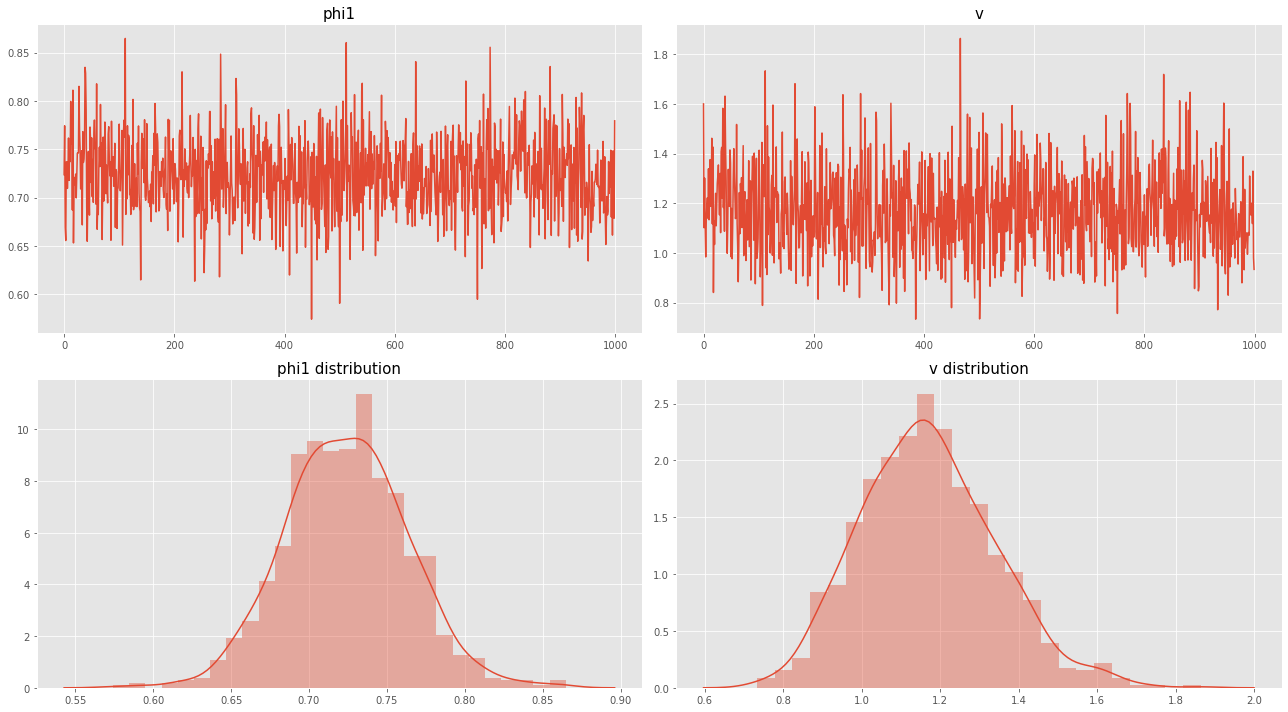

In [210]:
print(f'AR(1)\nActual phi1={phi}\nActual v={v}')
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(18, 10))

ax1[0].plot(phi_)

# Annual moving averages period = 12 months
ax1[1].plot(v_,)

ax1[0].set_title('phi1', fontsize=15)

ax1[1].set_title('v', fontsize=15)

sns.distplot(phi_, ax=ax2[0])
ax2[0].set_title('phi1 distribution', fontsize=15)

sns.distplot(v_, ax=ax2[1])
ax2[1].set_title('v distribution', fontsize=15)

plt.tight_layout()